In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from patsy import dmatrices
from scipy import stats

In [2]:
# PATH = "./"
PATH = "./linear_regression/"
df = pd.read_csv(f'{PATH}Auto.csv', dtype={'origin': 'category'})


In [3]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [4]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [5]:
df.dtypes

mpg              float64
cylinders          int64
displacement     float64
horsepower        object
weight             int64
acceleration     float64
year               int64
origin          category
name              object
dtype: object

In [6]:
df = df[df['horsepower'] != '?']
df = df.astype({'horsepower':float})

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["horsepower"], df["mpg"], test_size=0.20, random_state=42)

In [8]:
# model = sm.OLS.from_formula("mpg ~ horsepower", data=df)
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.647
Model:                            OLS   Adj. R-squared (uncentered):              0.646
Method:                 Least Squares   F-statistic:                              572.4
Date:                Fri, 08 Nov 2019   Prob (F-statistic):                    1.43e-72
Time:                        16:35:17   Log-Likelihood:                         -1287.3
No. Observations:                 313   AIC:                                      2577.
Df Residuals:                     312   BIC:                                      2580.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
horsepower     0.1799      0.008     23.926      0.000       0.165       0.195
==============================================================================
Omnibus:                       13.778   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.160
Skew:                          -0.231   Prob(JB):                       0.0169
Kurtosis:                       2.358   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
y_train_pred = result.predict(X_train)
print(f'MSE_Train: {metrics.mean_squared_error(y_train, y_train_pred)}')
print(f'MSE_Model: {result.mse_model}')

MSE_Train: 218.72747631976804
MSE_Model: 125607.5599119126


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc76001ae50>,
      dtype=object)

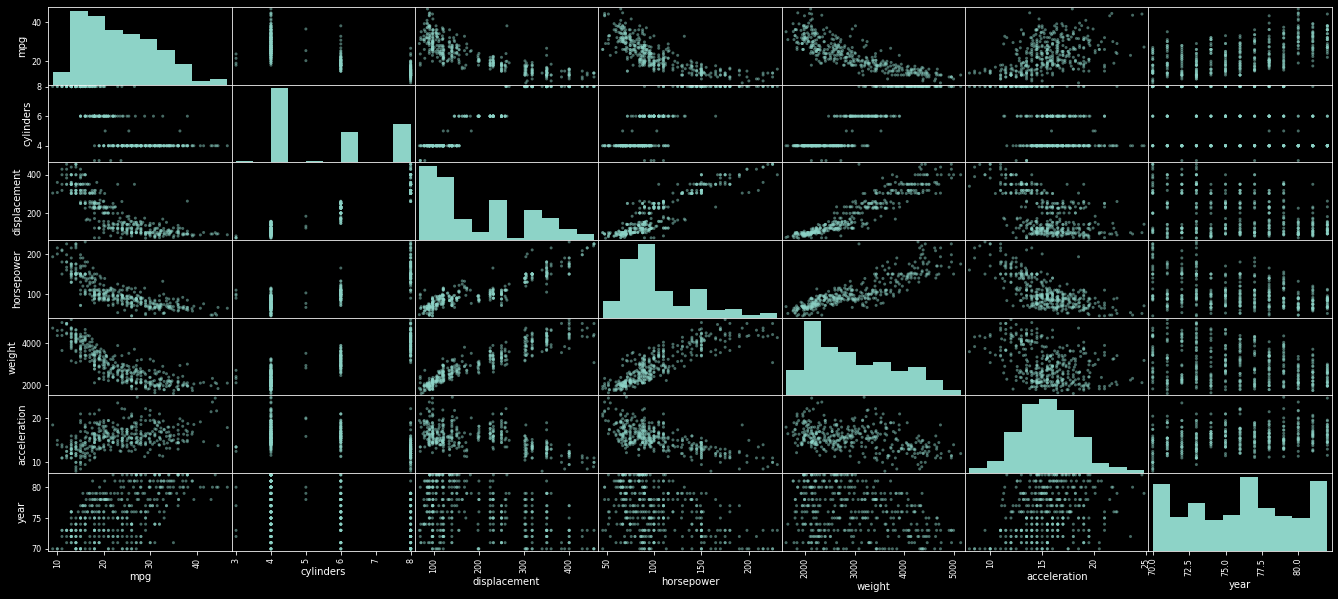

In [10]:
plt.rcParams["figure.figsize"] = [23, 10]
pd.plotting.scatter_matrix(df)

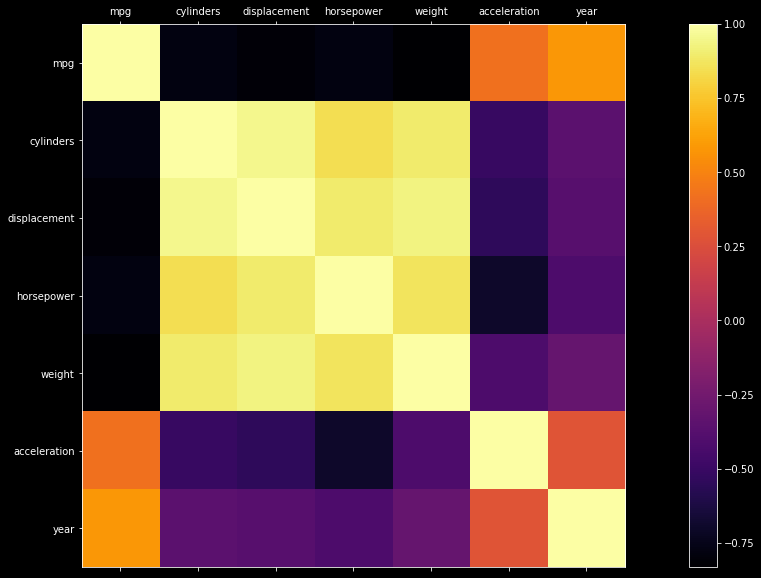

In [11]:
columns  = list(df.columns)
columns.remove("name")
columns.remove("origin")
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(),cmap="inferno")
fig.colorbar(cax)
ax.set_xticklabels([''] + columns)
ax.set_yticklabels([''] + columns)
plt.show()

In [12]:
def lin_reg(formula, dataframe_train, dataframe_valid):
    
    y_train, X_train = dmatrices(formula, data=dataframe_train, return_type='dataframe')   
    y_valid, X_valid = dmatrices(formula, data=dataframe_valid, return_type='dataframe')
    model = sm.OLS(y_train, X_train) 
    result = model.fit()

    # y_train_pred = result.predict(X_train)
    # print(f'MSE_Train: {metrics.mean_squared_error(y_train, y_train_pred)}')

    # y_valid_pred = result.predict(X_valid)
    # print(f'MSE_Test: {metrics.mean_squared_error(y_valid, y_valid_pred)}\n')

    return result

In [36]:
formulas = [
    'mpg ~ horsepower',
    'mpg ~ I(np.log(horsepower) + weight) + cylinders + year',
    'mpg ~ cylinders * displacement * horsepower + weight - acceleration + year',
    'mpg ~ acceleration + year',
    'mpg ~ I(np.log(displacement) + weight) * cylinders'
]

In [37]:
df_train, df_valid = train_test_split(df, test_size=0.20, random_state=42)

In [51]:
results = []
for formula in formulas:
    x = lin_reg(formula, df_train, df_valid)
    results.append((formula, x))

In [52]:
numeric_df_train = df_train[columns]
numeric_df_valid = df_valid[columns]

def compute_z_score(dataframe):
    return (np.abs(stats.zscore(dataframe)))

no_outliers_train = numeric_df_train [(compute_z_score(numeric_df_train ) < 3).all(axis=1)]
no_outliers_valid = numeric_df_valid [(compute_z_score(numeric_df_valid ) < 3).all(axis=1)]



In [53]:
results_out = []
for formula in formulas:
    x = lin_reg(formula, no_outliers_train, no_outliers_valid)
    results_out.append((formula, x))

In [55]:
msemod = pd.DataFrame(dict([(formula, x.mse_model) for formula,x in results]), index=['Initial dataset'])
without_out = pd.DataFrame(dict([(formula, x.mse_model) for formula,x in results_out]), index=['Without outliners'])
msemod.append(without_out)

,mpg ~ horsepower,mpg ~ I(np.log(horsepower) + weight) + cylinders + year,mpg ~ cylinders * displacement * horsepower + weight - acceleration + year,mpg ~ acceleration + year,mpg ~ I(np.log(displacement) + weight) * cylinders
Initial dataset,12089.492203,5334.424762,1901.641097,4035.299244,4784.963270
Without outliners,12261.920972,5245.042033,1865.559380,3885.642545,4687.118103
